In [1]:
import pandas as pd
cols = [
    "status","duration","crediPreprocessing pipeline and train-test splitt_history","purpose","amount",
    "savings","employment","installment_rate","personal_status",
    "guarantors","residence","property","age","other_installment",
    "housing","credits","job","dependents","phone","foreign_worker",
    "target"
]
df = pd.read_csv("../data/german.data", sep=" ", names=cols)
df.head()

,status,duration,credit_history,purpose,amount,savings,employment,installment_rate,personal_status,guarantors,...,property,age,other_installment,housing,credits,job,dependents,phone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [2]:
df["target"].value_counts(normalize=True)

target
1    0.7
2    0.3
Name: proportion, dtype: float64

In [3]:
df["target_binary"] = df["target"].map({1: 0, 2: 1})

In [4]:
df[["target", "target_binary"]].head()

,target,target_binary
0,1,0
1,2,1
2,1,0
3,1,0
4,2,1


In [5]:
X = df.drop(columns=["target", "target_binary"])
y = df["target_binary"]

X.shape, y.shape

((1000, 20), (1000,))

In [6]:
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

cat_cols, num_cols

/var/folders/pt/w30j5vtd1qj0nfnj2n1869hw0000gn/T/ipykernel_50358/1006655460.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X.select_dtypes(include="object").columns


(Index(['status', 'credit_history', 'purpose', 'savings', 'employment',
        'personal_status', 'guarantors', 'property', 'other_installment',
        'housing', 'job', 'phone', 'foreign_worker'],
       dtype='str'),
 Index(['duration', 'amount', 'installment_rate', 'residence', 'age', 'credits',
        'dependents'],
       dtype='str'))

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((800, 20), (200, 20))

In [10]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape

((800, 61), (200, 61))

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

In [12]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_reg.fit(X_train_processed, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [13]:
y_train_proba = log_reg.predict_proba(X_train_processed)[:, 1]
y_test_proba = log_reg.predict_proba(X_test_processed)[:, 1]

In [14]:
roc = roc_auc_score(y_test, y_test_proba)
pr = average_precision_score(y_test, y_test_proba)

print(f"ROC-AUC: {roc:.3f}")
print(f"PR-AUC:  {pr:.3f}")

ROC-AUC: 0.806
PR-AUC:  0.633


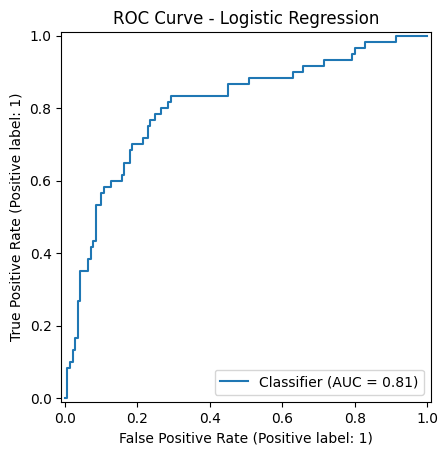

In [15]:
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve - Logistic Regression")
plt.show()

In [16]:
import numpy as np

print("Mean predicted prob:", np.mean(y_test_proba))
print("Actual positive rate:", np.mean(y_test))

Mean predicted prob: 0.44793958180487264
Actual positive rate: 0.3


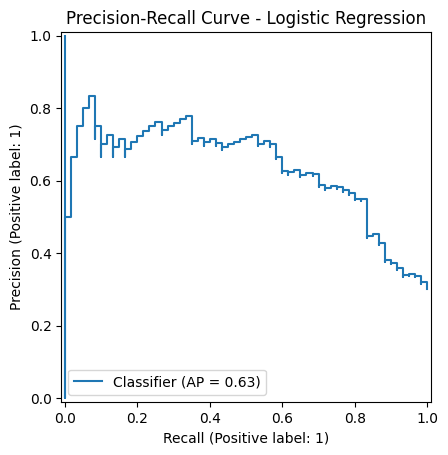

In [17]:
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve - Logistic Regression")
plt.show()

In [18]:
y_test_pred = (y_test_proba >= 0.5).astype(int)

print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.89      0.73      0.80       140
           1       0.56      0.80      0.66        60

    accuracy                           0.75       200
   macro avg       0.73      0.76      0.73       200
weighted avg       0.79      0.75      0.76       200

